In [20]:
# Core libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


Data loading & cleaning (robust datetime parsing)

In [45]:
dataset = pd.read_csv("Data/UberDataset.csv")


dataset = dataset.replace('#', np.nan)
dataset = dataset.dropna(subset=['CATEGORY', 'PURPOSE'])


# Robust datetime parsing (handles '-' and '/' in dates)
# --- robust datetime parsing supporting two formats ('-' and '/')
def parse_two_formats(s):
    dt = pd.to_datetime(s, format='%m-%d-%Y %H:%M', errors='coerce')
    mask = dt.isna()
    if mask.any():
        dt2 = pd.to_datetime(s[mask], format='%m/%d/%Y %H:%M', errors='coerce')
        dt.loc[mask] = dt2
    return dt

dataset['START_TS'] = parse_two_formats(dataset['START_DATE'])
dataset['END_TS']   = parse_two_formats(dataset['END_DATE'])

# Duration (minutes)
dataset['duration_min'] = (dataset['END_TS'] - dataset['START_TS']).dt.total_seconds()/60.0

# Calendar parts
dataset['date']       = dataset['START_TS'].dt.date
dataset['year']       = dataset['START_TS'].dt.year
dataset['month']      = dataset['START_TS'].dt.month
dataset['month_name'] = dataset['START_TS'].dt.month_name()
dataset['weekday']    = dataset['START_TS'].dt.day_name()
dataset['hour']       = dataset['START_TS'].dt.hour

# Time-of-day bucket (as per your “day-night” concept)
bins   = [-1, 10, 15, 19, 24]  # 0–10 Morning, 10–15 Afternoon, 15–19 Evening, 19–24 Night
labels = ['Morning','Afternoon','Evening','Night']
dataset['day-night'] = pd.cut(dataset['hour'], bins=bins, labels=labels)

# PURPOSE cleanup
dataset['PURPOSE'] = dataset['PURPOSE'].fillna('Unknown')

# Drop rows missing critical fields
dataset = dataset.dropna(subset=['START_TS','END_TS','MILES']).copy()

dataset.head()


,START_DATE,END_DATE,CATEGORY,START,STOP,MILES,PURPOSE,START_TS,END_TS,duration_min,date,year,month,month_name,weekday,hour,day-night
0,01-01-2016 21:11,01-01-2016 21:17,Business,Fort Pierce,Fort Pierce,5.1,Meal/Entertain,2016-01-01 21:11:00,2016-01-01 21:17:00,6.0,2016-01-01,2016,1,January,Friday,21,Night
2,01-02-2016 20:25,01-02-2016 20:38,Business,Fort Pierce,Fort Pierce,4.8,Errand/Supplies,2016-01-02 20:25:00,2016-01-02 20:38:00,13.0,2016-01-02,2016,1,January,Saturday,20,Night
3,01-05-2016 17:31,01-05-2016 17:45,Business,Fort Pierce,Fort Pierce,4.7,Meeting,2016-01-05 17:31:00,2016-01-05 17:45:00,14.0,2016-01-05,2016,1,January,Tuesday,17,Evening
4,01-06-2016 14:42,01-06-2016 15:49,Business,Fort Pierce,West Palm Beach,63.7,Customer Visit,2016-01-06 14:42:00,2016-01-06 15:49:00,67.0,2016-01-06,2016,1,January,Wednesday,14,Afternoon
5,01-06-2016 17:15,01-06-2016 17:19,Business,West Palm Beach,West Palm Beach,4.3,Meal/Entertain,2016-01-06 17:15:00,2016-01-06 17:19:00,4.0,2016-01-06,2016,1,January,Wednesday,17,Evening


Quick structure, missingness, numerics

In [46]:
print("Shape:", dataset.shape, "\n")
print(dataset.dtypes, "\n")
print("Missing values per column:\n", dataset.isna().sum(), "\n")

# Numeric-only describe (compatible across pandas versions)
num_cols = dataset.select_dtypes(include=[np.number]).columns
dataset[num_cols].describe()


Shape: (653, 17) 

START_DATE              object
END_DATE                object
CATEGORY                object
START                   object
STOP                    object
MILES                  float64
PURPOSE                 object
START_TS        datetime64[ns]
END_TS          datetime64[ns]
duration_min           float64
date                    object
year                     int32
month                    int32
month_name              object
weekday                 object
hour                     int32
day-night             category
dtype: object 

Missing values per column:
 START_DATE      0
END_DATE        0
CATEGORY        0
START           0
STOP            0
MILES           0
PURPOSE         0
START_TS        0
END_TS          0
duration_min    0
date            0
year            0
month           0
month_name      0
weekday         0
hour            0
day-night       0
dtype: int64 



,MILES,duration_min,year,month,hour
count,653.000000,653.000000,653.0,653.000000,653.00000
mean,11.196325,23.398162,2016.0,6.416539,14.82389
std,22.986429,25.769640,0.0,3.973976,4.81733
min,0.500000,2.000000,2016.0,1.000000,0.00000
25%,3.200000,11.000000,2016.0,3.000000,12.00000
50%,6.400000,18.000000,2016.0,6.000000,15.00000
75%,10.400000,28.000000,2016.0,11.000000,18.00000
max,310.300000,330.000000,2016.0,12.000000,23.00000


Unique values for object columns

In [47]:
obj = (dataset.dtypes == 'object')
object_cols = list(obj[obj].index)

unique_values = {}
for col in object_cols:
    unique_values[col] = dataset[col].nunique()
unique_values


{'START_DATE': 652,
 'END_DATE': 652,
 'CATEGORY': 2,
 'START': 131,
 'STOP': 137,
 'PURPOSE': 10,
 'date': 216,
 'month_name': 11,
 'weekday': 7}

Countplots — CATEGORY, PURPOSE

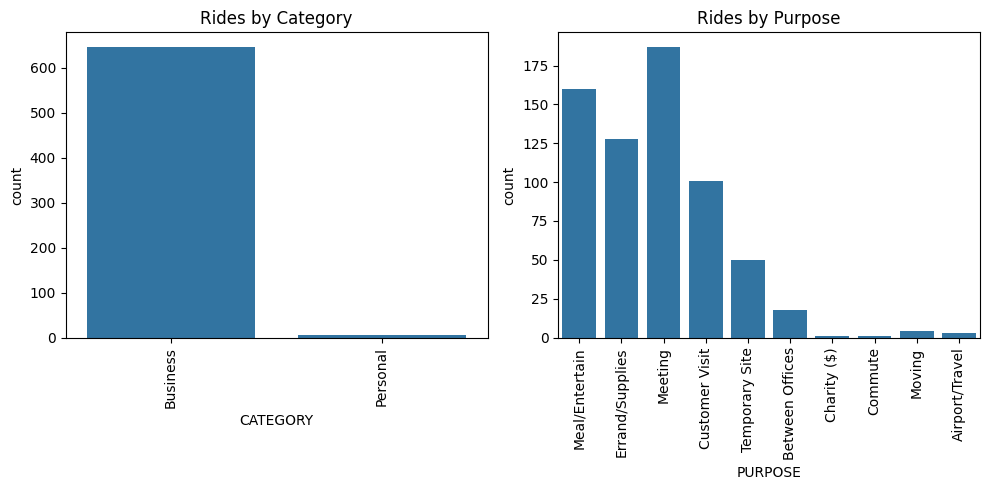

In [48]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.countplot(x=dataset['CATEGORY'])
plt.title('Rides by Category')
plt.xticks(rotation=90)

plt.subplot(1,2,2)
sns.countplot(x=dataset['PURPOSE'])
plt.title('Rides by Purpose')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


Countplot — time of day (“day-night”)

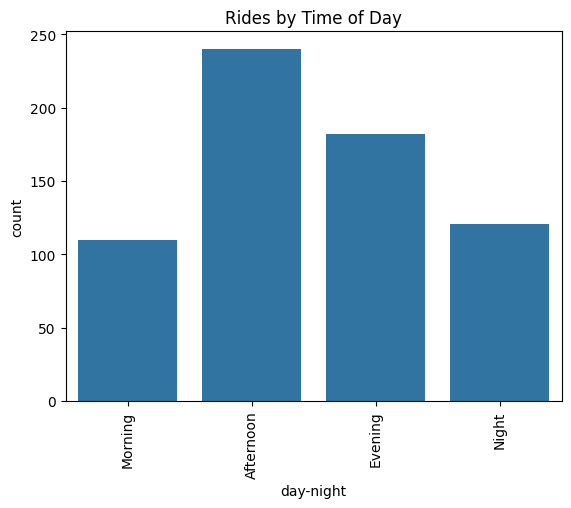

In [49]:
sns.countplot(x=dataset['day-night'])
plt.title('Rides by Time of Day')
plt.xticks(rotation=90)
plt.show()


Compare PURPOSE by CATEGORY

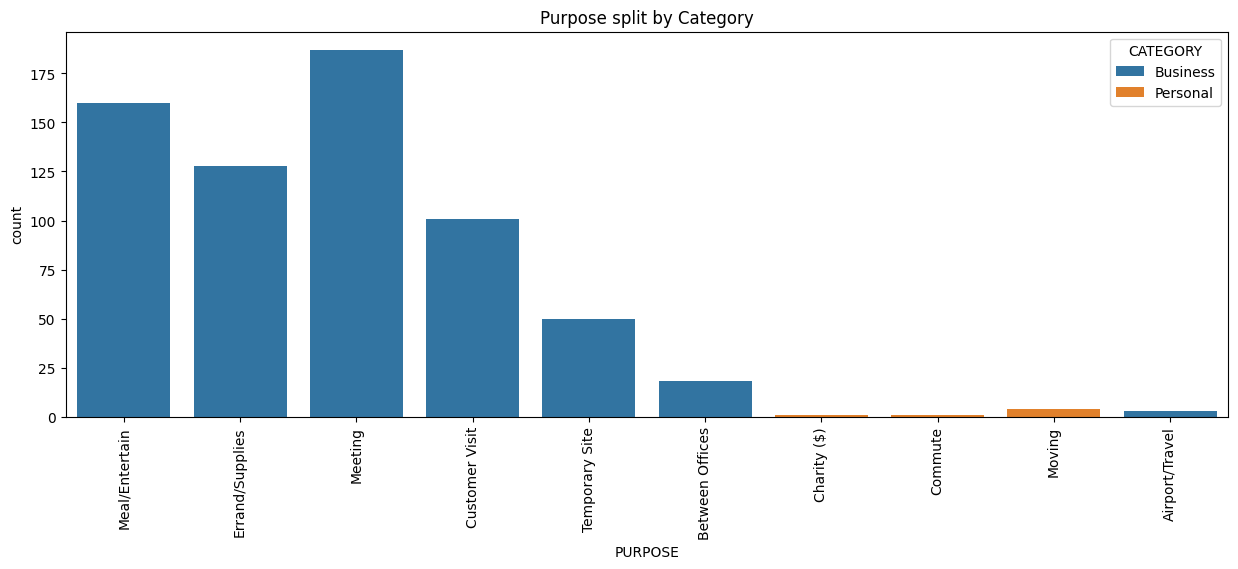

In [50]:
plt.figure(figsize=(15,5))
sns.countplot(data=dataset, x='PURPOSE', hue='CATEGORY')
plt.title('Purpose split by Category')
plt.xticks(rotation=90)
plt.show()


One-Hot Encode CATEGORY & PURPOSE → correlation heatmap

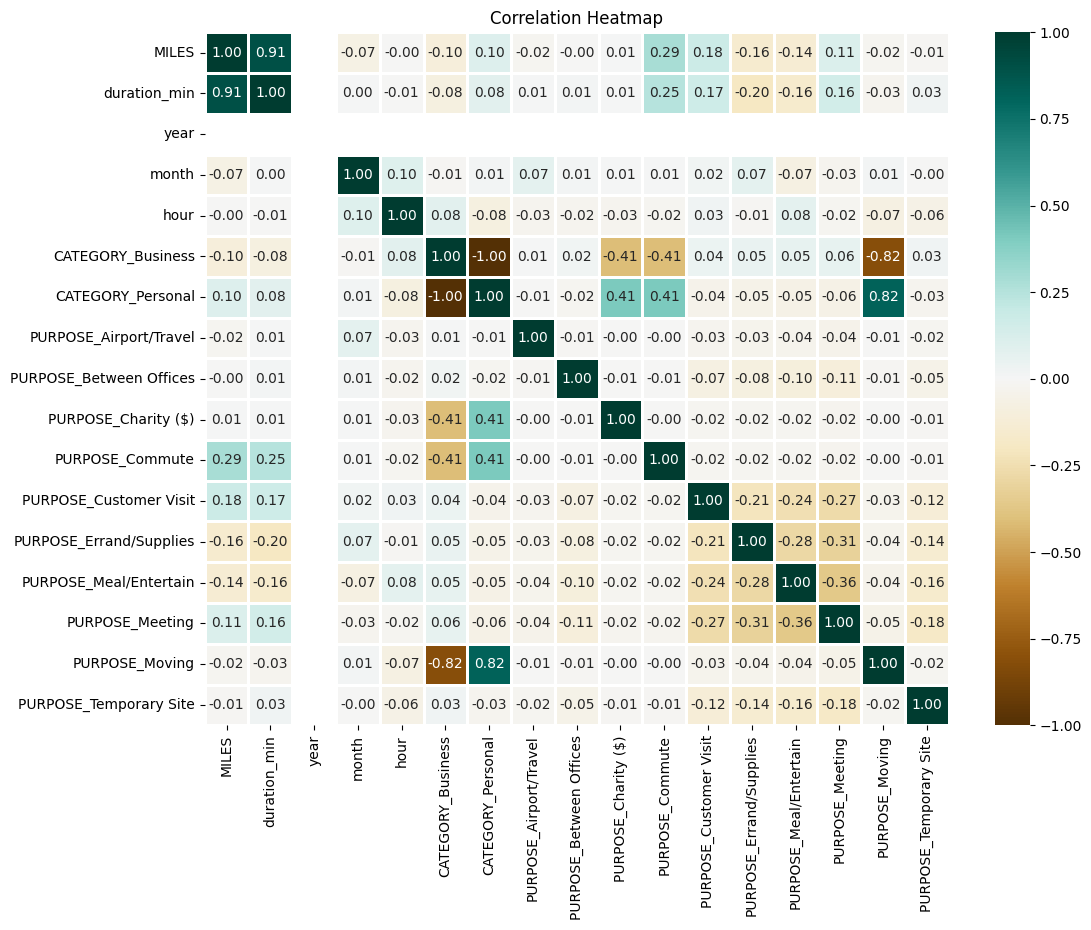

In [51]:
from sklearn.preprocessing import OneHotEncoder

# Columns to encode
oh_cols_list = ['CATEGORY', 'PURPOSE']

# OneHotEncoder with updated parameter
OH = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit & transform
oh_vals = OH.fit_transform(dataset[oh_cols_list])

# Convert to DataFrame with feature names
oh_df = pd.DataFrame(
    oh_vals,
    index=dataset.index,
    columns=OH.get_feature_names_out(oh_cols_list)
)

# Merge & keep numerics for correlation
df_final = pd.concat([dataset.drop(columns=oh_cols_list), oh_df], axis=1)
numeric_dataset = df_final.select_dtypes(include=['number'])

# Plot correlation heatmap
plt.figure(figsize=(12, 9))
sns.heatmap(numeric_dataset.corr(), cmap='BrBG', fmt='.2f', linewidths=2, annot=True)
plt.title('Correlation Heatmap')
plt.show()

Month analysis (labels + lineplot)

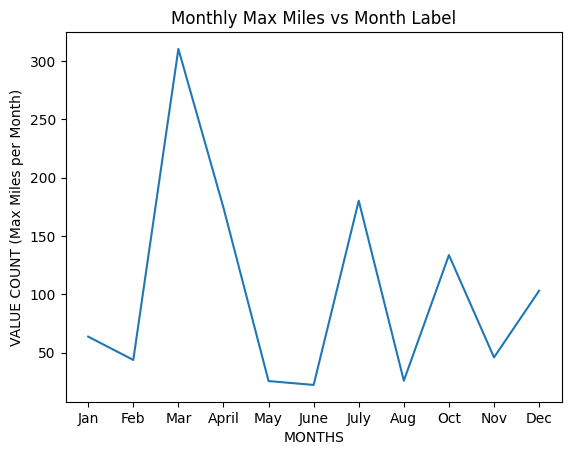

Monthly ride counts (unsorted):


,count
MONTH,
Jan,59
Feb,82
Mar,71
April,50
May,46
June,73
July,46
Aug,12
Oct,20


In [54]:
dataset['MONTH'] = dataset['START_TS'].dt.month.astype(float)

month_label = {1.0:'Jan', 2.0:'Feb', 3.0:'Mar', 4.0:'April',
               5.0:'May', 6.0:'June', 7.0:'July', 8.0:'Aug',
               9.0:'Sep', 10.0:'Oct', 11.0:'Nov', 12.0:'Dec'}
dataset['MONTH'] = dataset['MONTH'].map(month_label)

mon_counts = dataset['MONTH'].value_counts(sort=False)

# "Month total rides count vs Month ride max miles" (as in your snippet)
df_mon = pd.DataFrame({
    "MONTHS": mon_counts.index,
    "VALUE COUNT": dataset.groupby('MONTH', sort=False)['MILES'].max().reindex(mon_counts.index).values
})

p = sns.lineplot(data=df_mon, x="MONTHS", y="VALUE COUNT")
p.set(xlabel="MONTHS", ylabel="VALUE COUNT (Max Miles per Month)")
plt.title("Monthly Max Miles vs Month Label")
plt.show()

print("Monthly ride counts (unsorted):")
mon_counts


Day-of-week analysis (barplot)

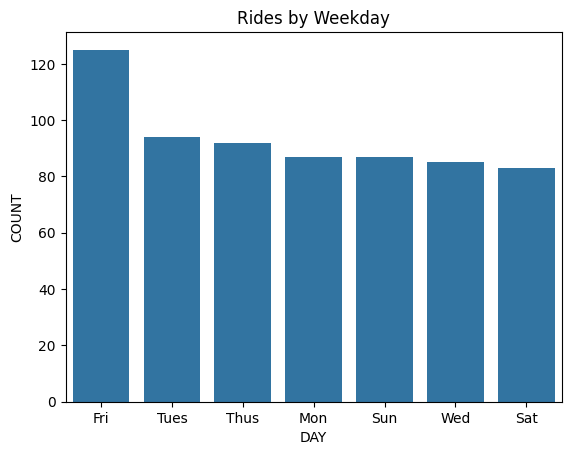

,count
DAY,
Fri,125
Tues,94
Thus,92
Mon,87
Sun,87
Wed,85
Sat,83


In [55]:
dataset['DAY'] = dataset['START_TS'].dt.weekday  # Monday=0
day_label = {0:'Mon', 1:'Tues', 2:'Wed', 3:'Thus', 4:'Fri', 5:'Sat', 6:'Sun'}
dataset['DAY'] = dataset['DAY'].map(day_label)

day_counts = dataset['DAY'].value_counts()
sns.barplot(x=day_counts.index, y=day_counts.values)
plt.xlabel('DAY'); plt.ylabel('COUNT'); plt.title('Rides by Weekday')
plt.show()

day_counts


Miles distribution — boxplots & “distplot”

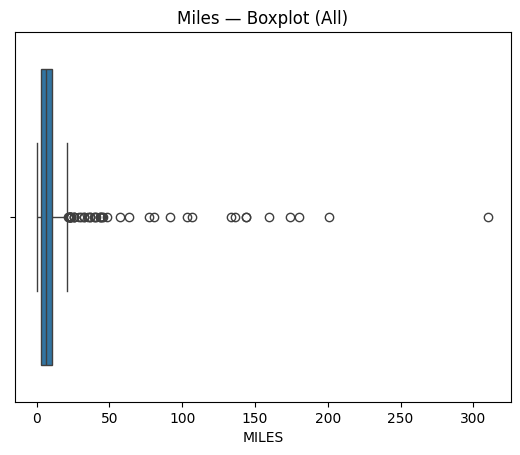

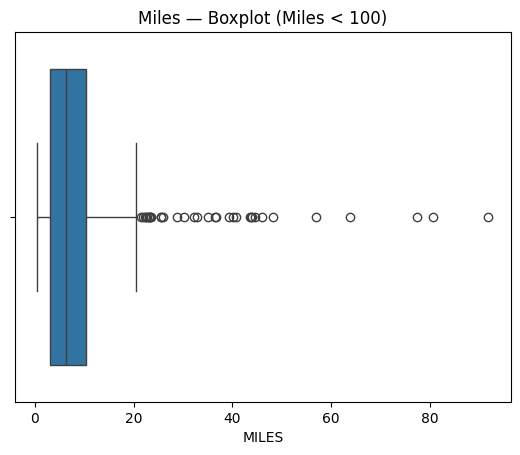

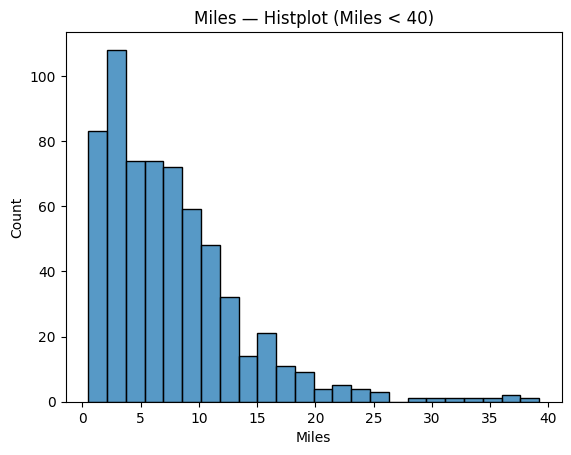

In [56]:
# Boxplot (all miles)
sns.boxplot(x=dataset['MILES'])
plt.title('Miles — Boxplot (All)')
plt.show()

# Boxplot (miles < 100)
sns.boxplot(x=dataset.loc[dataset['MILES'] < 100, 'MILES'])
plt.title('Miles — Boxplot (Miles < 100)')
plt.show()

# Histplot (miles < 40)
sns.histplot(dataset.loc[dataset['MILES'] < 40, 'MILES'])
plt.title('Miles — Histplot (Miles < 40)')
plt.xlabel('Miles')
plt.show()


A few hypothesis tests

In [57]:
# H1: Business vs Personal distance difference
mb = dataset.loc[dataset['CATEGORY']=='Business','MILES']
mp = dataset.loc[dataset['CATEGORY']=='Personal','MILES']

res = {}
if len(mb) > 1 and len(mp) > 1:
    # Welch t-test
    t_stat, t_p = stats.ttest_ind(mb, mp, equal_var=False, nan_policy='omit')
    # Mann-Whitney (distributional)
    u_stat, u_p = stats.mannwhitneyu(mb, mp, alternative='two-sided')
    res['business_mean'] = float(mb.mean())
    res['personal_mean'] = float(mp.mean())
    res['t_p'] = float(t_p)
    res['mannwhitney_p'] = float(u_p)

# H2: Category vs Purpose independence (chi-square)
cont = pd.crosstab(dataset['CATEGORY'], dataset['PURPOSE'])
chi2, p, dof, exp = stats.chi2_contingency(cont)
res['chi2_purpose_category_p'] = float(p)

# H3: Miles vs Duration correlation
sub = dataset[['MILES','duration_min']].dropna()
r, rp = stats.pearsonr(sub['MILES'], sub['duration_min'])
res['corr_miles_duration_r'] = float(r)
res['corr_miles_duration_p'] = float(rp)

res


{'business_mean': 10.970170015455952,
 'personal_mean': 35.58333333333333,
 't_p': 0.43455843944625316,
 'mannwhitney_p': 0.6971309730964348,
 'chi2_purpose_category_p': 8.718961093834278e-135,
 'corr_miles_duration_r': 0.9057424296726831,
 'corr_miles_duration_p': 6.89710925592493e-245}

Save cleaned data

In [58]:
CLEAN_PATH = os.path.join("Data", "uber_clean.csv")
dataset.to_csv(CLEAN_PATH, index=False)
print(f"Cleaned dataset saved at: {CLEAN_PATH}")


Cleaned dataset saved at: Data/uber_clean.csv
